# Predicting the overall ratings
Adam Jordan

## Intent

1. Use data from FIFA 19. Predict the Overall (OVR) skill Statistic for players in the FIFA 20 Edition. Train on all players from FIFA 19. Graphically represent the Overall data for the players in the Test Set.
2. How do each of the different attributes affect the Overall Score of a player? Are some more weighted than others?
3. What are the attributes of those with the highest ratings?
4. How have those skill attributes changed in significance over the last few games?


In [70]:
# imports & setup
import pandas as pd
import sklearn as sk
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import numpy as np
import re
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Importing the Data

In [8]:
# import the cleaned data for FIFA19
p19_df = pd.read_csv('cleaned_data/players_19.csv')
display(p19_df.head())

/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,...,player_positions_gk,player_positions_cdm,player_positions_rm,player_positions_lm,player_positions_cm,player_positions_lw,player_positions_lb,player_positions_rb,player_positions_lwb,preferred_foot_bin
0,0,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,33,1985-02-05,187,83,Portugal,...,0,0,0,0,0,1,0,0,0,0
1,1,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,31,1987-06-24,170,72,Argentina,...,0,0,0,0,0,0,0,0,0,1
2,2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,26,1992-02-05,175,68,Brazil,...,0,0,0,0,0,1,0,0,0,0
3,3,193080,https://sofifa.com/player/193080/david-de-gea-...,De Gea,David De Gea Quintana,27,1990-11-07,193,76,Spain,...,1,0,0,0,0,0,0,0,0,0
4,4,192985,https://sofifa.com/player/192985/kevin-de-bruy...,K. De Bruyne,Kevin De Bruyne,27,1991-06-28,181,70,Belgium,...,0,0,0,0,1,0,0,0,0,0


In [13]:
# import the cleaned data for FIFA20
p20_df = pd.read_csv('cleaned_data/players_20.csv')
display(p20_df.head())

,Unnamed: 0,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,...,player_positions_gk,player_positions_cdm,player_positions_rm,player_positions_lm,player_positions_cm,player_positions_lw,player_positions_lb,player_positions_rb,player_positions_lwb,preferred_foot_bin
0,0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,...,0,0,0,0,0,0,0,0,0,1
1,1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,...,0,0,0,0,0,1,0,0,0,0
2,2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,...,0,0,0,0,0,1,0,0,0,0
3,3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,...,1,0,0,0,0,0,0,0,0,0
4,4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,...,0,0,0,0,0,1,0,0,0,0


In [14]:
# get list of columns for predictions
target_cols = []
with open('cleaned_data/player_data_cols.csv') as cols_file:
    for col in cols_file:
        col = col.replace('\n', '')
        target_cols.append(col)

In [15]:
p19_df.columns

Index(['Unnamed: 0', 'sofifa_id', 'player_url', 'short_name', 'long_name',
       'age', 'dob', 'height_cm', 'weight_kg', 'nationality',
       ...
       'player_positions_gk', 'player_positions_cdm', 'player_positions_rm',
       'player_positions_lm', 'player_positions_cm', 'player_positions_lw',
       'player_positions_lb', 'player_positions_rb', 'player_positions_lwb',
       'preferred_foot_bin'],
      dtype='object', length=150)

In [41]:
# setup train & test sets
x_train = p19_df[target_cols]
y_train = p19_df['overall']

x_test = p20_df[target_cols]
y_test = p20_df['overall']

In [42]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [45]:
depths = range(4, 31, 2)
scores = []

for depth in depths:
    print(f'Evaluating depth of {depth}...')
    dec_tree = DecisionTreeRegressor(max_depth=depth)
    bagger = BaggingRegressor(dec_tree, n_estimators=100)
    result = cross_validate(bagger, x_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=10)
    score = np.abs(np.mean(result['test_score']))
    scores.append(score)
    print(f'Saved score of {score:.5f}.')

Evaluating depth of 4...
Saved score of 22.20081.
Evaluating depth of 6...
Saved score of 17.12530.
Evaluating depth of 8...
Saved score of 15.29002.
Evaluating depth of 10...
Saved score of 14.75165.
Evaluating depth of 12...
Saved score of 14.55376.
Evaluating depth of 14...
Saved score of 14.48894.
Evaluating depth of 16...
Saved score of 14.48467.
Evaluating depth of 18...
Saved score of 14.36473.
Evaluating depth of 20...
Saved score of 14.52474.
Evaluating depth of 22...
Saved score of 14.43094.
Evaluating depth of 24...
Saved score of 14.49064.
Evaluating depth of 26...
Saved score of 14.40468.
Evaluating depth of 28...
Saved score of 14.43477.
Evaluating depth of 30...
Saved score of 14.43678.


In [46]:
min_idx = np.argmin(scores)
best_depth = depths[min_idx]
best_score = scores[min_idx]

print(f'The best depth was {best_depth} with a score of {best_score:.5f}.')

The best depth was 18 with a score of 14.36473.


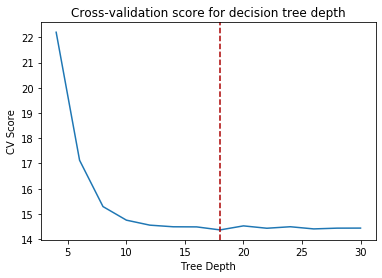

In [56]:
plt.plot(depths, scores)
plt.axvline(x=best_depth, color='#AA0000', linestyle='--')
plt.xlabel('Tree Depth')
plt.ylabel('CV Score')
plt.title('Cross-validation score for decision tree depth')
plt.show()

In [57]:
dec_tree = DecisionTreeRegressor(max_depth=best_depth)
bagger = BaggingRegressor(dec_tree, n_estimators=100)
bagger.fit(x_train_scaled, y_train)

The optimized and scaled tree results in 0.99491 accuracy.


In [58]:
accuracy = bagger.score(x_test_scaled, y_test)

print(f'The optimized and scaled tree results in {accuracy:.5f} accurate on the FIFA20 set.')

The optimized and scaled tree results in 0.99491 accurate on the FIFA20 set.


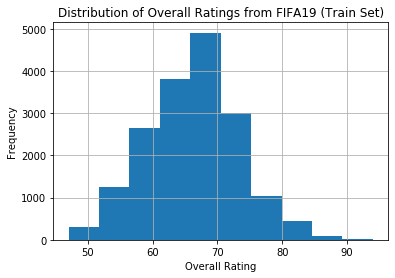

In [66]:
y_train.hist(bins=10)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings from FIFA19 (Train Set)')
plt.show()

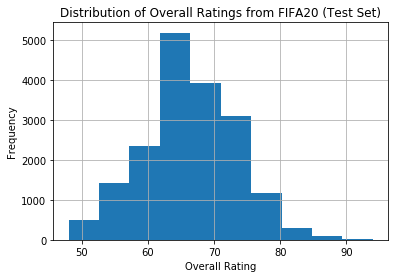

In [67]:
y_test.hist(bins=10)
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Overall Ratings from FIFA20 (Test Set)')
plt.show()

In [91]:
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)
lr_score = lr.score(x_test_scaled, y_test)

print(f'Checking Linear Regression against test set results in {lr_score:.5f} accurate.')

Checking Linear Regression against test set results in 0.92645 accurate.


In [92]:
coefs = zip(target_cols, lr.coef_)
coefs = sorted(coefs, key=lambda x: np.abs(x[1]), reverse=True)
for c in coefs:
    print(f'{c[0]}:{c[1]}')

gk_diving:3.967759248416059
gk_reflexes:3.7872420769572717
player_positions_gk:-3.6215960168704893
gk_positioning:3.4995008163400665
gk_handling:3.3931484995732393
defending:-3.3656771288399185
rdm:1.5997552145127951
cdm:1.5997552145127896
ldm:1.5997552145127891
rb:1.34269202142425
lb:1.3426920214242368
dribbling:1.3052499061625864
passing:-1.2483418831728645
lwb:1.1740840326200257
rwb:1.1740840326200173
movement_reactions:1.1535665528012902
value_eur:1.1373779603442884
gk_kicking:1.0383827190093522
defending_sliding_tackle:-0.9586384577803109
ls:0.9296292872241729
st:0.9296292872241589
rs:0.9296292872241487
attacking_heading_accuracy:0.8914140043839626
skill_ball_control:0.7641824681312954
player_positions_cm:-0.744617748896973
player_positions_cb:0.724711384619712
mentality_positioning:-0.7232160196663764
mentality_composure:0.7229630185494982
skill_moves:0.7073915570965988
cb:0.6713817866191267
lcb:0.6713817866191185
rcb:0.6713817866191093
mentality_interceptions:-0.6676472436389271

Using Linear Regression to determine the most important coefficents indicated that position was the most important element, but this is likely due to the structure of the data where goalkeepers have different stats than other players. Following position, defending, rdm, and cdm seemed to be the most important for non-goalkeepers. For goalkeepers, it was diving, reflexes, and positioning.

Secondarily, this clear separation caused by the goalkeeper/non-goalkeeper stat structure makes Linear Regression less desirable for a good result, helping to explain the much better performance given by Decision Tree.

In [96]:
pd.set_option('display.max_columns', None)
p19_df[p19_df['overall'] >= 92][['sofifa_id', 'short_name', 'overall', 'defending', 'rdm', 'cdm', 'gk_diving', 'gk_reflexes', 'gk_positioning']]

,sofifa_id,short_name,overall,defending,rdm,cdm,gk_diving,gk_reflexes,gk_positioning
0,20801,Cristiano Ronaldo,94,35.0,61,61,0.0,0.0,0.0
1,158023,L. Messi,94,32.0,61,61,0.0,0.0,0.0
2,190871,Neymar Jr,92,32.0,60,60,0.0,0.0,0.0


In [97]:
pd.set_option('display.max_columns', None)
p20_df[p20_df['overall'] >= 92][['sofifa_id', 'short_name', 'overall', 'defending', 'rdm', 'cdm', 'gk_diving', 'gk_reflexes', 'gk_positioning']]

,sofifa_id,short_name,overall,defending,rdm,cdm,gk_diving,gk_reflexes,gk_positioning
0,158023,L. Messi,94,39.0,66,66,0.0,0.0,0.0
1,20801,Cristiano Ronaldo,93,35.0,61,61,0.0,0.0,0.0
2,190871,Neymar Jr,92,32.0,61,61,0.0,0.0,0.0


In [98]:
# check against previous games
for file in ['players_15.csv', 'players_16.csv', 'players_17.csv', 'players_18.csv']:
    pold_df = pd.read_csv('cleaned_data/' + file)
    
    xold_test = pold_df[target_cols]
    yold_test = pold_df['overall']
    
    xold_test_scaled = scaler.transform(xold_test)
    
    old_accuracy = bagger.score(xold_test_scaled, yold_test)

    print(f'The accuracy for {file} is {old_accuracy:.5f}.')

The accuracy for players_15.csv is -2.49439.
The accuracy for players_16.csv is 0.97726.


/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The accuracy for players_17.csv is 0.97424.


/Users/xylamic/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The accuracy for players_18.csv is 0.99407.


The testing against older files indicates that the scoring mechanism has been very similar starting with FIFA18. Prior to that, it seems a different scoring mechanism was used, and dramatically different in FIFA15.